## Access ECMWF data on Azure

ECMWF data is available as a collection of GRIB2 files on Azure Blob Storage.

The file pattern for each GRIB2 file is `[date]/[thing-1]/0p4-beta/[thing-2]/[filename]`

where

field | description | example |
----- | ----------- | -------
date  | The date of the ... (forecast?) formated like "YYYMDD" | `20220106` |
thing-1 | ... | `00z` |
thing-2 | One of `enfo`, `oper`, `waef`, `wave`. | `enfo` |
filename | ... | `20220106000000-0h-enfo-ef.grib2`

### Downloading a file

We can interact with Azure Blob Filesystem using [adlfs](https://github.com/fsspec/adlfs). This lets us list and glob the filesystem, and download indivudal files. We'll download a file from 

In [1]:
import adlfs
import pathlib

fs = adlfs.AzureBlobFileSystem(account_name="ai4edataeuwest")
yesterday = fs.ls("ecmwf")[-1]

grib, index = fs.ls(f"{yesterday}/00z/0p4-beta/waef")[:2]
grib = pathlib.Path(grib)
index = pathlib.Path(index)

grib.name

'20220106000000-0h-waef-ef.grib2'

We'll download the GRIB2 and index file locally.

In [2]:
tmp = pathlib.Path("/tmp")

fs.download(str(grib), str(tmp / grib.name))
fs.download(str(index), str(tmp / index.name));

Which we can read with xarray.

In [3]:
import xarray as xr

ds = xr.open_dataset(tmp / grib.name, engine="cfgrib", filter_by_keys={'dataType': 'pf'})
ds

<xarray.Dataset>
Dimensions:     (number: 50, latitude: 451, longitude: 900)
Coordinates:
  * number      (number) int64 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    meanSea     float64 ...
  * latitude    (latitude) float64 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  datetime64[ns] ...
Data variables:
    mp2         (number, latitude, longitude) float32 ...
    swh         (number, latitude, longitude) float32 ...
    mwd         (number, latitude, longitude) float32 ...
    pp1d        (number, latitude, longitude) float32 ...
    mwp         (number, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-07T22:56 GRIB to CDM+CF via cfgrib-0.9.9...

And plot a variable.

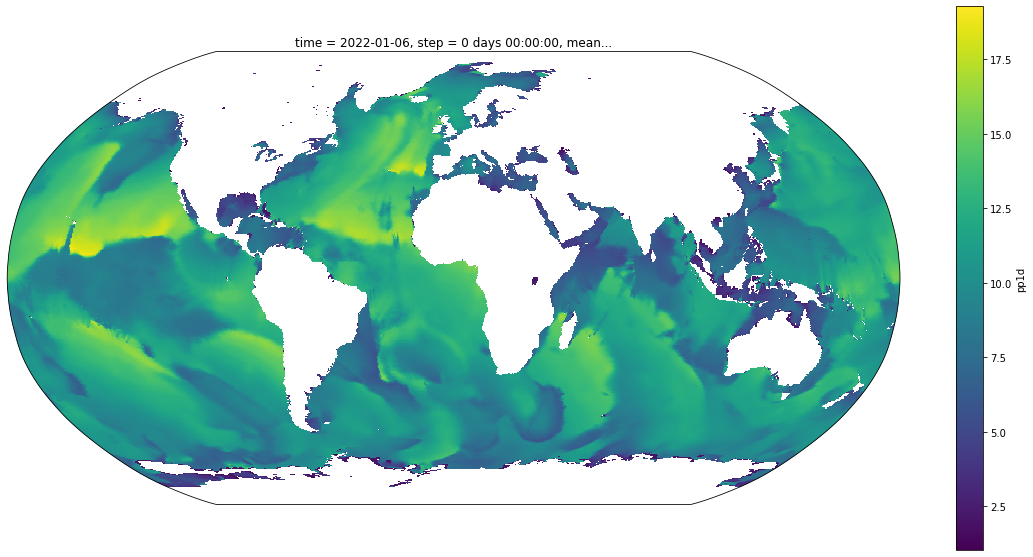

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings
import shapely

warnings.filterwarnings("ignore", category=shapely.errors.ShapelyDeprecationWarning)

average = ds.pp1d.mean(dim="number")

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(projection=ccrs.Robinson()))
average.plot(ax=ax, transform=ccrs.PlateCarree());